In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.append("../..")

In [64]:
from rom_tools.rom_manager import RomManager
from world_rando import parse_rules
from world_rando.coord import Coord

In [4]:
manager = RomManager("../../../roms/sm_clean.smc", "../../../roms/sm_junk.smc")
obj_names = manager.parse() # slow

In [5]:
header = obj_names["room_header_0x7a107"]
#level = make_level_from_room(header)

In [65]:
rules, tests = parse_rules.parse_rules(["../../encoding/rules/rules.yaml",
                                        "../../encoding/rules/model_checking_tests/model_checking_tests.yaml"])

In [7]:
mcz2 = tests["ModifiedConstructionZone2"]
samus_0 = mcz2[0].samus
samus_f = mcz2[1]
level = mcz2[0].level

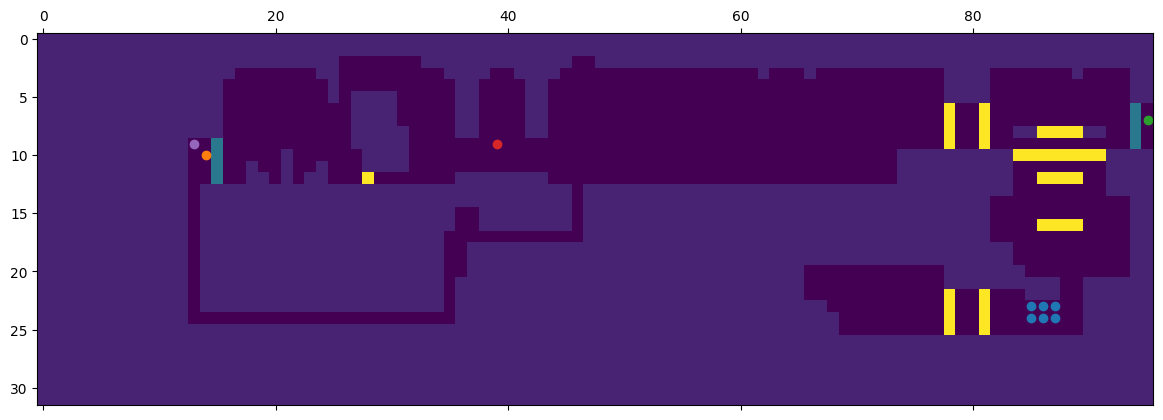

In [8]:
matshow(level.level.T)
scatter([85,86,87,85,86,87],[23,23,23,24,24,24])
scatter(14, 10)
scatter(95, 7)
scatter(39,9)
scatter(13,9)

In [9]:
from bdds.bdd_core import *

In [10]:
context = mk_context()

In [11]:
# First, build the normal trans

In [13]:
non_design_trans = mk_trans(header, context, level)

100%|███████████████████████████████████████████████████████████████████████████████| 3072/3072 [01:16<00:00, 40.16it/s]


In [14]:
non_design_trans = context.exist(["rule"], non_design_trans)

In [15]:
non_design_trans.count()

2396557391429632.0

In [16]:
non_design_closure = mk_closure(non_design_trans, context)

0 5454
1 14126
2 41451
3 62602
4 70314
5 69935
6 81512
7 48957
8 31083
9 31083


In [17]:
non_design_closure.count()

4.1568526325031895e+18

In [18]:
# Show that there is a softlock

In [19]:
samus_0, samus_f

((c(39,9)|V: 0, H: RUN, 0|STAND|ISet([])),
 (c(95,7)|V: 0, H: RUN, 0|STAND|ISet(['M', 'MB'])))

In [20]:
items_prev = set(prevs) - set(["x_prev", "y_prev", "pose_prev", "vt_prev", "vh_prev", "vv_prev", "room_id_prev"])

In [21]:
no_items_prev = context.true
for i in items_prev:
    no_items_prev &= context.add_expr(f"{i} = 0")

In [22]:
from data_types.item_set import item_mapping

In [23]:
from functools import reduce

In [24]:
def reduce_and(context, clauses):
    return reduce(lambda x, y: x & y, clauses, context.true)

def mk_itemset_expr(context, itemset, when="prev"):
    clauses = []
    for i in item_mapping:
        if i in itemset:
            clause = context.add_expr(f"{i}_{when} = 1")
        else:
            clause = context.add_expr(f"{i}_{when} = 0")
        clauses.append(clause)
    return reduce_and(context, clauses)

In [25]:
samus_0_bdd = context.add_expr("x_prev = 39 & y_prev = 9 & pose_prev = 0") & mk_itemset_expr(context, samus_0.items, "prev")

In [26]:
samus_f_bdd = context.add_expr("x_next = 95 & y_next = 7 & pose_next = 0") & mk_itemset_expr(context, samus_f.items, "next")

In [27]:
reach_goal = non_design_closure & samus_f_bdd

In [28]:
reach_goal.count()

59404.0

In [29]:
reachable = samus_0_bdd & non_design_closure

In [30]:
reachable.count()

7188.0

In [31]:
reachable_pt = context.let(next_to_temp, reachable)

In [32]:
reach_goal_tn = context.let(prev_to_temp, reach_goal)

In [33]:
non_softlocks = context.exist(prevs + nexts, reachable_pt & reach_goal_tn)

In [34]:
context.count(non_softlocks)

4708

In [35]:
# These are the softlock states! Reachable states that cannot reach the goal

In [36]:
softlocks2 = context.exist(prevs, reachable_pt & ~non_softlocks)

In [37]:
# Seems high...

In [38]:
context.count(softlocks2)

2480

In [39]:
# Not sure why this definition doesn't work
softlocks = context.exist(prevs + nexts, reachable_pt & ~reach_goal_tn)

In [40]:
context.count(softlocks)

7188

In [41]:
(softlocks & non_softlocks).count()

4708.0

In [42]:
n = 0
for s in context.pick_iter(softlocks2):
    print(s["x_temp"], s["y_temp"])
    n+=1
    if n > 20:
        break
#context.pick(softlocks2)

13 9
13 10
13 11
13 12
13 13
13 14
13 15
13 15
13 16
13 17
13 18
13 19
13 20
13 21
13 22
13 22
13 22
13 10
13 11
13 10
13 11


In [ ]:
# Actual design_conditioned

In [43]:
# Add variables to the context
new_vs = {}
for x in range(85,88):
    for y in range(23,26):
        new_vs[f"is_solid_{x}_{y}"] = (0,1)
context.declare(**new_vs)

In [44]:
level2 = level.copy()

In [45]:
# Edit to add unknowns
level2.level.flags.writeable = True
for x in range(85,88):
    for y in range(23,26):
        level2.level[x,y] = AbstractTile.UNKNOWN

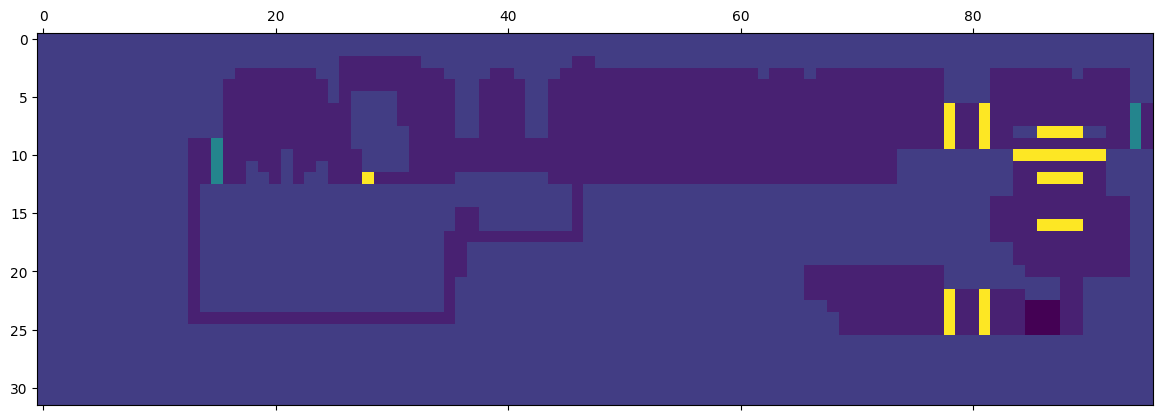

In [46]:
matshow(level2.level.T)

In [114]:
%%time
design_trans = mk_trans(header, context, level2)

100%|███████████████████████████████████████████████████████████████████████████████| 3072/3072 [01:18<00:00, 38.89it/s]

CPU times: user 1min 18s, sys: 196 ms, total: 1min 19s
Wall time: 1min 18s


In [115]:
design_trans = context.exist(["rule"], design_trans)

In [116]:
design_trans.count()

1.2242334236027126e+18

In [117]:
%%time
design_closure = mk_closure(design_trans, context)

0 58465
1 120420
2 229694
3 277037
4 289852
5 387410
6 418290
7 318264
8 198495
9 198495
CPU times: user 1min 31s, sys: 797 ms, total: 1min 31s
Wall time: 1min 31s


In [51]:
design_closure.count()

1.3638650158012495e+21

In [52]:
d_reach_goal = design_closure & samus_f_bdd

In [53]:
d_reachable = samus_0_bdd & design_closure

In [54]:
d_reachable_pt = context.let(next_to_temp, d_reachable)

In [55]:
d_reach_goal_tn = context.let(prev_to_temp, d_reach_goal)

In [56]:
d_non_softlocks = context.exist(prevs + nexts, d_reachable_pt & d_reach_goal_tn)

In [57]:
d_softlocks2 = context.exist(prevs, d_reachable_pt & ~non_softlocks)

In [58]:
context.count(d_softlocks2)

631498

In [59]:
good_designs = context.forall(temps, d_non_softlocks)

In [60]:
context.pick(good_designs)

In [61]:
# Check the "good" design

In [66]:
mcz1 = tests["ModifiedConstructionZone1"]

In [67]:
mcz_level = mcz1[0].level

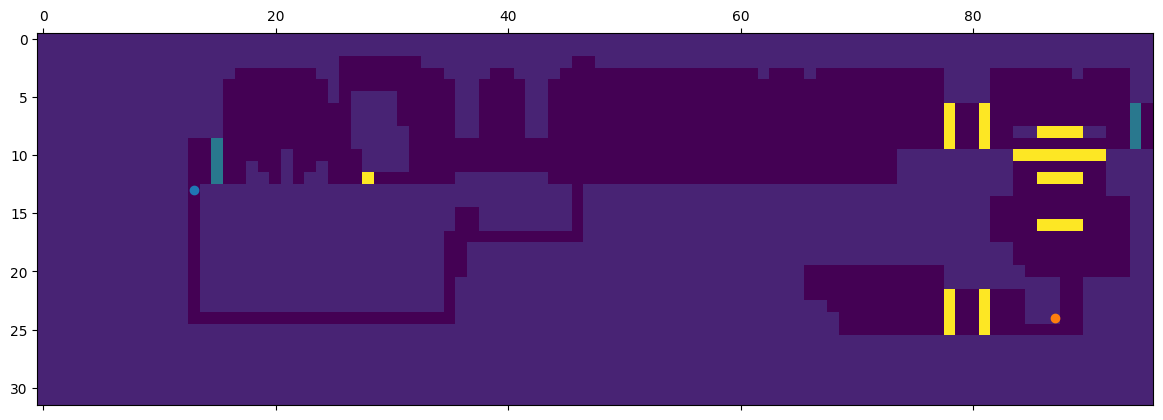

In [68]:
matshow(mcz1[0].level.level.T)
scatter(13,13)
scatter(87,24)

In [69]:
mcz_trans = mk_trans(header, context, mcz_level)

100%|███████████████████████████████████████████████████████████████████████████████| 3072/3072 [01:20<00:00, 38.06it/s]


In [70]:
mcz_trans = context.exist(["rule"], mcz_trans)

In [71]:
mcz_closure = mk_closure(mcz_trans, context)

0 30650
1 41262
2 53692
3 61318
4 57524
5 65695
6 72362
7 49297
8 30986
9 30986


In [72]:
mcz_reach_goal = mcz_closure & samus_f_bdd

In [73]:
mcz_reachable = samus_0_bdd & mcz_closure

In [74]:
mcz_reachable_pt = context.let(next_to_temp, mcz_reachable)

In [75]:
mcz_reach_goal_tn = context.let(prev_to_temp, mcz_reach_goal)

In [76]:
mcz_non_softlocks = context.exist(prevs + nexts, mcz_reachable_pt & mcz_reach_goal_tn)

In [77]:
mcz_softlocks2 = context.exist(prevs, mcz_reachable_pt & ~mcz_non_softlocks)

In [78]:
context.count(mcz_softlocks2)

1895

In [79]:
#TODO: what is causing this to be considered a softlock state?

In [80]:
context.pick(mcz_softlocks2)

{'room_id_temp': 41223,
 'x_temp': 13,
 'y_temp': 10,
 'pose_temp': 2,
 'vt_temp': 1,
 'vh_temp': 0,
 'vv_temp': 2,
 'B_temp': 0,
 'PB_temp': 0,
 'SPB_temp': 0,
 'S_temp': 0,
 'M_temp': 1,
 'G_temp': 0,
 'SA_temp': 0,
 'V_temp': 0,
 'GS_temp': 0,
 'SB_temp': 0,
 'HJ_temp': 0,
 'MB_temp': 1,
 'CB_temp': 0,
 'WB_temp': 0,
 'E_temp': 0,
 'PLB_temp': 0,
 'Spazer_temp': 0,
 'RT_temp': 0,
 'XR_temp': 0,
 'IB_temp': 0,
 'SJ_temp': 0,
 'Kraid_temp': 0,
 'Phantoon_temp': 0,
 'Draygon_temp': 0,
 'Ridley_temp': 0,
 'Botwoon_temp': 0,
 'Spore_Spawn_temp': 0,
 'Golden_Torizo_temp': 0,
 'Bomb_Torizo_temp': 0,
 'Mother_Brain_temp': 0,
 'Crocomire_temp': 0,
 'Ceres_Ridley_temp': 0,
 'Drain_temp': 0,
 'Shaktool_temp': 0,
 'START_temp': 0,
 'Statues_temp': 0}

In [81]:
real_softlocks = softlocks2 & ~mcz_softlocks2

In [82]:
context.count(real_softlocks)

585

In [83]:
# Make sure they all do not have the morph ball
context.count(real_softlocks & context.add_expr("MB_prev = 0"))

585

In [84]:
# Now find designs where the real softlocks are not reachable

In [85]:
good_trans = d_reachable_pt & ~real_softlocks

In [86]:
good_designs = context.exist(prevs + temps, good_trans)

In [87]:
context.count(good_designs)

1

In [88]:
context.pick(good_designs)

{}

In [89]:
# Sanity check

In [90]:
all_solid = context.true
for x in range(85,88):
    for y in range(23,25):
        all_solid &= context.add_expr(f"is_solid_{x}_{y} = 1")

In [91]:
design_vars = list(new_vs.keys())

In [92]:
context.exist(design_vars, d_reachable & all_solid) == mcz_reachable

True

In [93]:
# Find designs that cannot reach the real_softlocks

In [94]:
# all_solid cannot reach the real softlocks
context.count(d_reachable_pt & all_solid & real_softlocks)

0

In [95]:
bad_designs = context.exist(prevs + temps, d_reachable_pt & real_softlocks)

In [104]:
context.count(~bad_designs, care_vars = design_vars)

511

In [97]:
# Good designs are not bad!

In [99]:
start_to_end = context.exist(prevs + nexts, design_closure & samus_0_bdd & samus_f_bdd)

In [100]:
context.pick(~bad_designs & start_to_end)

{'is_solid_85_23': 0,
 'is_solid_85_24': 0,
 'is_solid_85_25': 0,
 'is_solid_86_23': 0,
 'is_solid_86_24': 0,
 'is_solid_86_25': 0,
 'is_solid_87_23': 0,
 'is_solid_87_24': 1,
 'is_solid_87_25': 0}

In [107]:
context.count(bad_designs)

1

In [105]:
context.count(~bad_designs & start_to_end, care_vars = design_vars)

63

In [103]:
context.count(~start_to_end, care_vars=design_vars)

448